# Solving Max-Cut problem using Dwave Quantum Annealing
This notebook presents how to solve the NP-hard problem Max-Cut using Quantum Annealing.
In Quantum Annealing, we specify a Quadratic Uncontrained Binary Optimization (QUBO) model that is implemented as the final Hamiltonian in an plausible adiabatic evolution.
A QUBO can be expressed as
$$ (QUBO) \min_{\bf{x}} \sum_{i,j}^n Q_{ij}x_i x_j + \sum_{i}^n Q_{ii}_i x_i, \bf{x} \in \{0,1\}^n
$$

Besides the many appplications of this formalism, solving a general QUBO is NP-hard.

where we minimize an quadratic expression with respect to an $n$-dimensional vector of binary variables $\bf{x}$, the matrix $Q$ determines the quadratic and linear part of the QUBO. Notice that in this case we separate the elements of the diagonal of $Q$ given the fact that $x_i^2 = x_i, x_i \in \{0,1\}$. NWe can define a graph $G = (V,E)$ such that we have a vertex for every binary variable and include an edge for each non-zero term in $Q$ (technically speaking the boolean matrix of $Q$ is the adjacency matrix of $G$).

This QUBO can be easily transformed to a well-studies problem in Physics, the Ising model. In the Ising model, we represent the energy of paramagnetic materials by assuming that each particle of the system $i$ has a corresponding spin (measured along the $Z$ axis) $\sigma_i^Z \in \{+1,-1\}$. These particles interact with their immediate neighbors in a graph $G = (V,E)$ and are subject to an external magnetic field that interacts with each particle by accounting for an energy $\pm h_i$. The interaction with other particles can lead to an increase of the total energy if their spins are oriented in the same direction ($J_{ij} > 0$, ferromagnetic), or in the opposite direction ($J_{ij} < 0$, antiferromagnetic). The function that accounts for the total energy of the system is known as the Hamiltonian $H_f$.
$$  H_f = \sum_{(ij) \in E}J_{ij}\sigma_i^Z \sigma_j^Z + \sum_{i \in V} h_i \sigma_i^Z
$$

Using the transformation $\sigma_i^Z = 1 - 2x_i$ and the corresponding tranformations for the matrices $Q$ and $J$ and vector $h$ we obtain the Hamiltonian from the original QUBO .

The Dwave devices start from an initial Hamiltonian $H_i$ and drive a time evolution to the final Hamiltonian $H_f$ slowly enough such that at every time step, represented by the adimensional time $s=t/T$ where $T$ is the total time, the system remains at its ground state, minimizing its energy. The energy of the system is described then as 
$$ H(s) = A(s)H_i + B(s)H_f
$$

Where $A(s)$ and $B(s)$ are time functions such that $A(0)=B(1)=1$ and $A(1)=B(0)=0$ (in practice we just need $A(0)/B(0) >> 1$ and $B(1)/A(1) >> 1$).

Usually the initial Hamiltonian is defined such that its ground state is a total superposition, and the usual choice is having
$$ H_i = \sum_{i=1}^n \sigma_i^X
$$

This procedure allows that at the end of the annealing procedure $s=1$, the ground state of $H_f$ is obtained. If that is the case and $H_f$ represents our $(QUBO)$ we would solve the optimization problem. Quantum Annealing offers an analog implementation of this algorithm, and uses niobium superconducting quantum interference device (SQUID) to implement the spins as qubits. Practically speaking, the Quantum Annealing can be considered as a metaheuristic for solving combinatorial optimization problems by translating them into constrained Ising problems. Whether this method actually takes advantage of quantum mechanics is still debated.

## Max-cut
The Max-cut problem, which is a combinatorial optimization problem deals with finding the largest cut of a graph $G = (V,E)$, where each edge has a weight $w_{ij}, \forall (ij) \in E$. The cut of a graph is defined as a separation of the vertices of the graph, and its value is the sum of the edges weights that are crossed by the cut.

A simple formulation of this problem can be proposed using binary variables $s_i \in \{+1,-1\}, \forall i \in V$ that represent whether each vertex belong to one side ($V^+$) or the other ($V^-$) of the cut.
In that case, to maximize the cut's value we maximize the number of edges that connect the two set of vertices $\delta(V^+)$.
$$ C = \sum_{(i,j) \in \delta(V^+)} (-1)w_{ij}s_i s_j
$$
where we include the term $s_i s_j$ that is $-1$ if the cut crosses the edge between $V^+$ and $V^-$ times a sign correction.
Since there is no way that we can know the set $\delta(V^+)$ a priori, we add the weights times the spins for all edges in the graph.
$$ \sum_{(i,j) \in E} w_{ij}s_i s_j = \\
\qquad \sum_{(i,j) \in E(V^+)}w_{ij} + \sum_{(i,j) \in E(V^+)}w_{ij} - \sum_{(i,j) \in \delta(V^+)} w_{ij}s_i s_j = \\
\qquad \qquad \sum_{(i,j) \in E}w_{ij} - 2\sum_{(i,j) \in \delta(V^+)} w_{ij}s_i s_j
$$
There is and offset given by the weights of the edges belonging to the same set. Writing the full optimization problem we have:
$$ C_{max} = \max_{\bf{s} \in \{+1,-1\}^n} \frac{1}{2} \sum_{(i,j) \in E} w_{ij}(1 - s_i s_j) = \\
\qquad \frac{1}{2} \left( \sum_{(i,j) \in E} w_{ij} + \min_{\bf{s} \in \{+1,-1\}^n}  \sum_{(i,j) \in E} w_{ij}s_i s_j \right)
$$

From the description above, we can observe that the Max-cut has a direct relationship with the Ising model. In this case, there is no external field $h$ and the coefficients of $J$ are the weights of the given graph.
Now we can solve the Max-cut problem via the Ising model.

In [6]:
import networkx as nx
import dimod
import matplotlib.pyplot as plt

In [11]:
# Define exact solver for small cases
exact_sampler = dimod.reference.samplers.ExactSolver()
# Simmulated annealing code (this will be considered the "simulator")
sim_ann = dimod.SimulatedAnnealingSampler()
# Dwave device
from dwave.system.composites import EmbeddingComposite
from dwave.system.samplers import DWaveSampler
sampler = EmbeddingComposite(DWaveSampler())

### First example
Degree 2 graph (famous because was first instance that Fhari worked with for QAOA)

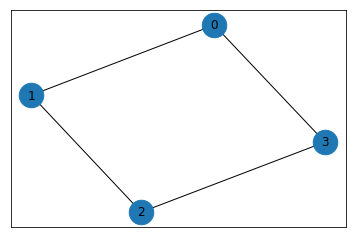

In [9]:
E1     =[(0,1,1.0),(1,2,1.0),(2,3,1.0),(3,0,1.0)] 

G1     = nx.Graph()
G1.add_weighted_edges_from(E1)

# Generate plot of the Graph
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G1)

nx.draw_networkx(G1, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [12]:
# Define Ising problem parameters
def ising_maxcut(G):
    '''
    G is a NetworkX graph
    '''
    h = {v: 0. for v in G.nodes()}
    J = {(u, v): 1 for u, v in G.edges}
    return h,J

In [16]:
h, J = ising_maxcut(G1)
exact_sampler.sample_ising(h, J)

SampleSet(rec.array([([-1, -1, -1, -1],  4., 1), ([ 1, -1, -1, -1],  0., 1),
           ([ 1,  1, -1, -1],  0., 1), ([-1,  1, -1, -1],  0., 1),
           ([-1,  1,  1, -1],  0., 1), ([ 1,  1,  1, -1],  0., 1),
           ([ 1, -1,  1, -1], -4., 1), ([-1, -1,  1, -1],  0., 1),
           ([-1, -1,  1,  1],  0., 1), ([ 1, -1,  1,  1],  0., 1),
           ([ 1,  1,  1,  1],  4., 1), ([-1,  1,  1,  1],  0., 1),
           ([-1,  1, -1,  1], -4., 1), ([ 1,  1, -1,  1],  0., 1),
           ([ 1, -1, -1,  1],  0., 1), ([-1, -1, -1,  1],  0., 1)],
          dtype=[('sample', 'i1', (4,)), ('energy', '<f8'), ('num_occurrences', '<i4')]), [0, 1, 2, 3], {}, 'SPIN')

In [ ]:
G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)